# Unsupervised approach


In [222]:
%load_ext autoreload
%autoreload 2
from  tm_common import *

IN_COLAB, output_dir = tm_get_working_config()

if IN_COLAB : 
    import locale
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    
    def getpreferredencoding(do_setlocale = True):
        return "UTF-8"

    locale.getpreferredencoding = getpreferredencoding
    print(locale.getpreferredencoding())


In [223]:
if IN_COLAB : 
    !pip install pyLDAvis
    !pip install bertopic
    !pip install -U sentence-transformers
    !pip install --upgrade ipykernel
    !pip install pandas==1.5.3

In [224]:
import os
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
from collections.abc import Iterable

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sentence_transformers import SentenceTransformer


In [225]:
sto_token_series_clean = np.load(f"{output_dir}token_series_clean.npy", allow_pickle=True)

In [226]:

sto_body = np.load(f"{output_dir}bag_of_words_body.npy", allow_pickle=True)
sto_titles = np.load(f"{output_dir}bag_of_words_titles.npy", allow_pickle=True)
sto_corpus_tags = np.load(f"{output_dir}corpus_tags.npy", allow_pickle=True)
text_corpus = np.load(f"{output_dir}corpus.npy", allow_pickle=True)

In [227]:

# Check sto_body only contains strings :
if isinstance(sto_body, Iterable) and not isinstance(sto_body, str):
    for doc in sto_body :
        if not all(isinstance(word,str) for word in doc):
          print(doc)
    # raise TypeError("Make sure that the iterable only contains strings.")


### Take sample for further computation

In [228]:
print(sto_body.shape)
print(sto_corpus_tags.shape)
print(sto_titles.shape)

(30912,)
(30912,)
(30912,)


In [229]:
# # only take sample for further computation
# NB_DOCS = 2000
# s_corpus_core = sto_body[:NB_DOCS]
# s_tags   = sto_corpus_tags[:NB_DOCS]
# s_titles = sto_titles[:NB_DOCS]
s_corpus_core = sto_body
s_tags   = sto_corpus_tags
s_titles = sto_titles

Let's concatenate title and corpus of each document for unsupervised learning.

In [230]:
s_corpus = [ np.append(s_titles[i] ,s_corpus_core[i]) for i in range(NB_DOCS)]

In [231]:
print(s_titles[0])
print(s_corpus[0])

['NLTK', 'Automatically', 'translating', 'similar', 'word']
['NLTK' 'Automatically' 'translating' 'similar' 'word' 'picture' 'goal'
 'making' 'model' 'product' 'review' 'Python' 'NLTK' 'Gensim' 'varying'
 'Problem' 'Everything' 'great' 'unigrams' 'bigram' 'start' 'topic'
 'repeated' 'information' 'Topic' 'might' 'contain' "'good" 'product'
 "'good" 'Topic' 'might' 'contain' "'great" 'product' "'great" 'human'
 'obviously' 'conveying' 'information' 'obviously' "'good" 'product'
 "'great" 'product' 'distinct' 'bigram' 'algorithmically' 'determine'
 "'good" 'product' "'great" 'product' 'similar' 'enough' 'translate'
 'occurrence' 'maybe' 'appears' 'often' 'corpus' 'played' 'around'
 'WordNet' 'Synset' 'tree' 'little' 'luck' 'turn' 'good' "'adjective"
 'great' "'adjective" 'satellite' 'therefore' 'None' 'path' 'similarity'
 'thought' 'process' 'Part' 'speech' 'sentence' 'correct' 'Synset'
 'Compute' 'similarity' 'Synsets' 'threshold' 'compute' 'occurrence'
 'word' 'Replace' 'least' 'occurr

## Topic modeling
Let's search for theme in text collection
# id too word dictionary

gensim is a NLP python package and unables the bag-of-words vector representation. Each document is a ligne and in each lign the id of the word appering and it's frequency in the document.

In [232]:
id2word = corpora.Dictionary(s_corpus)

In [233]:
# Term Document Frequency
corpus = [ id2word.doc2bow(text) for text in s_corpus]

In [234]:
print(s_corpus[0])

['NLTK' 'Automatically' 'translating' 'similar' 'word' 'picture' 'goal'
 'making' 'model' 'product' 'review' 'Python' 'NLTK' 'Gensim' 'varying'
 'Problem' 'Everything' 'great' 'unigrams' 'bigram' 'start' 'topic'
 'repeated' 'information' 'Topic' 'might' 'contain' "'good" 'product'
 "'good" 'Topic' 'might' 'contain' "'great" 'product' "'great" 'human'
 'obviously' 'conveying' 'information' 'obviously' "'good" 'product'
 "'great" 'product' 'distinct' 'bigram' 'algorithmically' 'determine'
 "'good" 'product' "'great" 'product' 'similar' 'enough' 'translate'
 'occurrence' 'maybe' 'appears' 'often' 'corpus' 'played' 'around'
 'WordNet' 'Synset' 'tree' 'little' 'luck' 'turn' 'good' "'adjective"
 'great' "'adjective" 'satellite' 'therefore' 'None' 'path' 'similarity'
 'thought' 'process' 'Part' 'speech' 'sentence' 'correct' 'Synset'
 'Compute' 'similarity' 'Synsets' 'threshold' 'compute' 'occurrence'
 'word' 'Replace' 'least' 'occurring' 'word' 'occurring' 'word' 'Ideally'
 'though' 'algorith

In [235]:
print(len(corpus))
print(len(corpus[0]))
print(len(corpus[1]))
print(corpus[0][:10])

2000
89
66
[(0, 2), (1, 4), (2, 4), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2)]


In [236]:
# train the model
tfidf = gensim.models.TfidfModel(corpus)

In [237]:
tfidf_corpus = tfidf[corpus]

In [238]:
print(len(tfidf_corpus))
print(len(tfidf_corpus[0]))
print(len(tfidf_corpus[1]))
print(tfidf_corpus[0][:10])

2000
89
66
[(0, 0.17006089073354708), (1, 0.34012178146709415), (2, 0.34012178146709415), (3, 0.06326176625286392), (4, 0.07274039261473657), (5, 0.05927168356258999), (6, 0.04902124166685223), (7, 0.08503044536677354), (8, 0.04775344634441814), (9, 0.17006089073354708)]


### Memory representation : Compressed Sparse Row (csr) matrix
The issue with tf-idf matrix representation (one line per document, one column per corpus word) is that it's almost an empty matrix (most of elements are null). We don't want to store that in memory. To elevate this issue we represent our matrix with the sparse matrix format.
Sparse matrix representation allows to store only non-zero elements.
- data : list of all non-zeros values of the matrix
- indices : column index of each element
- indptr : is the start and stop ptr of each row in the sparse matrix, the row 0 is data[ indptr[0], indptr[1] ], therefore it contains the number of row + 1 elements. (when start = next stop only one value is saved )

Even with this memory representation, **reduction dimension is still needed**. The dimensionality of the input (number of word in the vocabulary * number of posts) would be too large for computation. 

In [239]:

def tfidf_to_xsparse(tfidf_in, nb_lines, nb_cols)  :
  """Convert the TF-IDF corpus into a sparse matrix"""
  rows, cols, data = [], [], []
  for i, doc in enumerate(tfidf_in):
      for j, value in doc:
          rows.append(i)
          cols.append(j)
          data.append(value)
  return csr_matrix((data, (rows, cols)), shape=(nb_lines, nb_cols))

X_sparse = tfidf_to_xsparse(tfidf_corpus, len(tfidf_corpus), len(id2word) )


In [240]:
def xspare_to_tfidf(xsparse, dictionnary) :
  corpus_bag_of_words =  []
  feature_names = list(dictionnary.token2id.keys())
  for  idx, v in zip(xsparse.indices, xsparse.data) :
    print(idx , v)
    corpus_bag_of_words.append((idx , v))
  return corpus_bag_of_words

In [241]:
X_sparse.shape


(2000, 46686)

The sparse data representation allows to not store 0 if the word does not exist in the corpus but it still represent one line per document and the frequency of apparition of a unique per columns.

## TF-IDF dimension reduction : LSA

SVD (Sigular value decomposition) is a dimension reduction technique based on eigenvectors decoposition and works better on sparse data. In the difference of PCA that uses dimension reduction on the covariance matrix (symetric matrix, the bases vectors are orthogonal and can be normalized to be orhonormal), SVD works on the data matrix. If term word count or TF-IDF is given as input it corresponds to LSA : latent semantic analysis


In [242]:

# Perform Truncated SVD (similar to PCA) on the sparse matrix
svd = TruncatedSVD(n_components=1700, n_iter=7, random_state=33)
svd.fit(X_sparse)
X_svd = svd.transform(X_sparse)


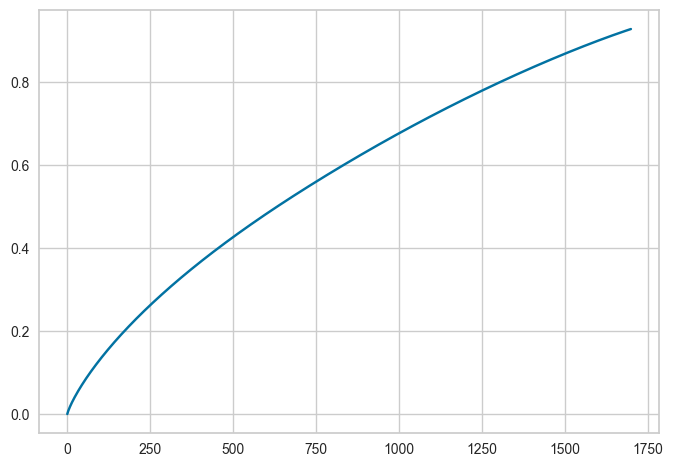

In [243]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.show()

In [244]:
NB_COMPONENTS = 1100
print(f"Percentage of ratio explained with {NB_COMPONENTS} components: {svd.explained_variance_ratio_[:1100].sum() *100 } %" )
print(NB_COMPONENTS/ X_sparse.shape[1] *100)

Percentage of ratio explained with 1100 components: 71.9604774091981 %
2.3561667309257595


In [245]:
# Perform Truncated SVD (similar to PCA) on the sparse matrix
svd = TruncatedSVD(n_components=NB_COMPONENTS, n_iter=7, random_state=33)
svd.fit(X_sparse)
X_svd = svd.transform(X_sparse)

Here we select 1100 principal components, so we diminish the size of the corpus token representation from 48388 to 1100 so 2% of the original data amount.

This keeps 70% of the explained variance. 

In [246]:
def data_preparation(text_copus,svd, v=False) :
  """ bag-of-words to lsa coordinates"""
  if v :
    print("From bag-of-words to lsa coordinates example : ")
    print(f"The document is represented by {len(text_copus[0])} words" )
    print("The first word is : ",text_copus[0][0])
  # Term Document Frequency
  text_corpus_encoded = [ id2word.doc2bow(word) for word in text_copus]
  if v :
    print("First word encoded: ",text_corpus_encoded[0][0])
  # tf_idf
  tf_idf = tfidf[text_corpus_encoded]
  if v :
    print("tf_idf.shape : " , len(tf_idf[0]))
    print("First word tf-idf representation: ",tf_idf[0][0])
  # sparse representation
  sparse_tfidf =  tfidf_to_xsparse(tf_idf, len(tfidf_corpus), len(id2word))
  # PCA
  lsa_coordinates = svd.transform(sparse_tfidf)
  if v :
    print("lsa_coordinates.shape : " , lsa_coordinates.shape)
    print("First word lsa coordinates: ", lsa_coordinates[0][0])
  return lsa_coordinates

In [247]:
lsa_coordinates_example = data_preparation([s_corpus[0]], svd, v=True)

From bag-of-words to lsa coordinates example : 
The document is represented by 133 words
The first word is :  NLTK
First word encoded:  (0, 2)
tf_idf.shape :  89
First word tf-idf representation:  (0, 0.17006089073354708)


lsa_coordinates.shape :  (2000, 1100)
First word lsa coordinates:  0.0874326677377846


We want to be able to interpret the lsa coordinates and further algorithms output in term of semantic. To do that we need to be able from lsa coordinates to retrieve which word there correspond to. Actually the cannot be done with truncatedSVD , as it applies a truncation and the function inverse_transform is not the inverse of the function transform. As we cannot know the number of words present as input, we will only generate to 10 maximum weight and convert there idexes into words from the dictionnary.

In [248]:
def data_decoding(lsa_coordinates, svd, dic, nb_docs, v=False):
  """ lsa coordinates to most representative 10 words """
  corpus_representation = []
  tfidf = svd.inverse_transform(lsa_coordinates)[:nb_docs]
  if v :
    print("tfdif matrix shape : ", tfidf.shape)
    print("tfidf values", tfidf)
  for text_idx in range(nb_docs):
    idx = tfidf[text_idx].argsort()[::-1][:10]
    if v :
      print("idexes of the most predominqnts 10 words :  ", idx)
    feature_names = list(id2word.token2id.keys())
    corpus_representation.append( [ str(feature_names[i]) for i in idx] )
  if v :
    print("Predominamts 10 words of the lsa representation :")
    print(corpus_representation)
  return corpus_representation



In [249]:
output = data_decoding(lsa_coordinates_example, svd, id2word, 1, v=True)

tfdif matrix shape :  (1, 46686)
tfidf values [[0.08772071 0.17544141 0.17544141 ... 0.00080692 0.00020173 0.00020173]]
idexes of the most predominqnts 10 words :   [63 88  2  1 30 69 16 18 19  0]
Predominamts 10 words of the lsa representation :
[['product', 'word', "'great", "'good", 'corpus', 'similar', 'Synset', 'Topic', 'WordNet', "'adjective"]]


let's check if words were part of the input bag-of-words

In [250]:
np.all(np.isin(output, s_corpus[0]) )

True

Now let's view the new space support vectors, on which words (which were our axes in inputs) are mainly supported bu the nex pricipal components base. Let's compute coherence score on this topics.

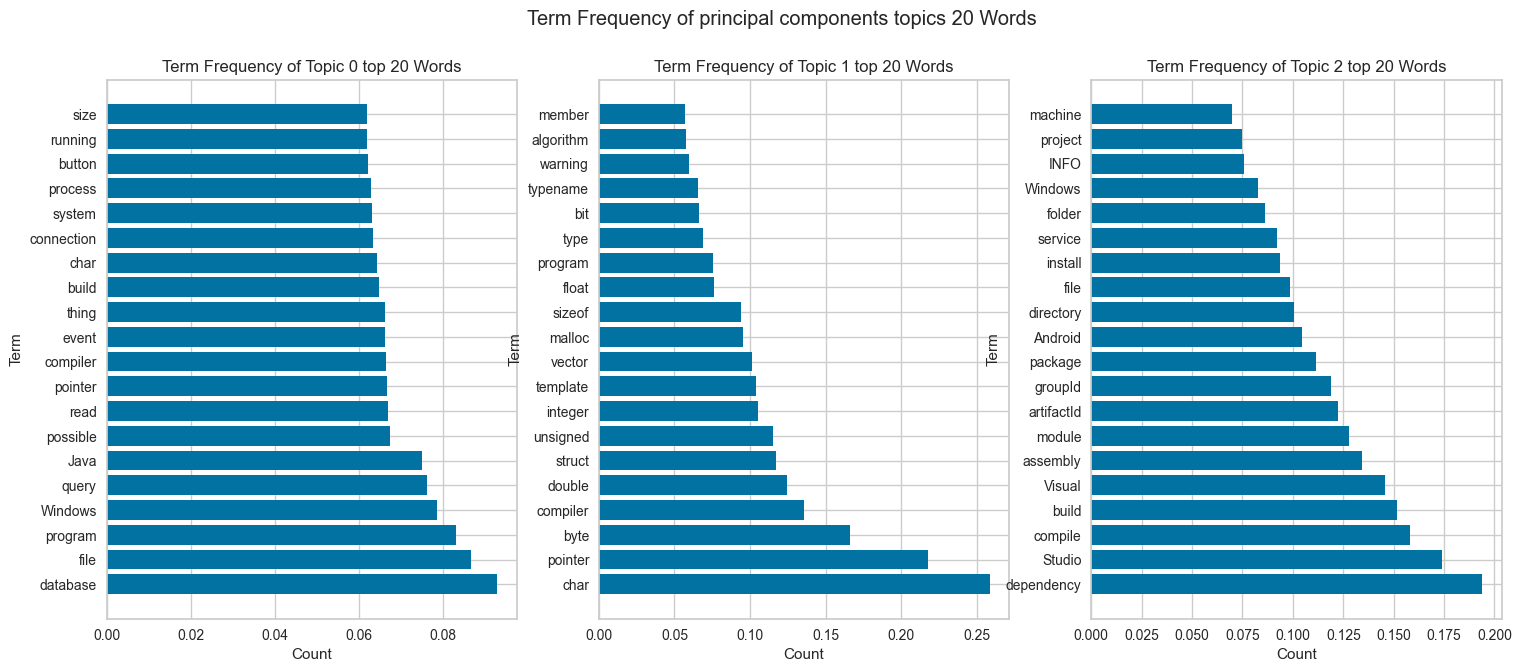

In [251]:
def plot_main_words_per_topics(topics_idx, topics_weight, dic):

    words = []
    feature_names = list(dic.token2id.keys())
    topics_words = [ str(feature_names[ind]) for ind in topics_idx]
    for i in range(len(topics_weight)):
        data = {
                "term" : topics_words[i],
                "term_weight" : topics_weight[i]
            }
        words.append(pd.DataFrame([data]))

    return pd.concat(words)




N = 20
term_freq_df = []
NB_TOPICS = 3
for i, component in enumerate(svd.components_[:NB_TOPICS]):
    topics_idx = component.argsort()[::-1][:N]  # Get the indices of the top 10 features
    topics_weight = np.sort(component)[::-1][:N]
    term_freq_df.append(plot_main_words_per_topics(topics_idx, topics_weight, id2word))

fig , axs = plt.subplots(1,NB_TOPICS,figsize=(6*NB_TOPICS,7))
for k in range(NB_TOPICS) :
    df = term_freq_df[k]
    # axs[k].clf()
    axs[k].barh(
        df['term'],
        df['term_weight']
    )
    axs[k].set_xlabel("Count")
    axs[k].set_ylabel("Term")
    axs[k].set_title(f"Term Frequency of Topic {k} top {N} Words")
fig.suptitle(f"Term Frequency of principal components topics {N} Words")
plt.show()



Interpretation :
- PC1 : javascript
- PC2 : html
- PC3 :
- PC4
- PC5 : authentification , server
- PC6 : C

In [252]:
print("Topics to model")
NB_TOPICS_FOR_EVALUATION = 30
NB_WORDS_PER_TOPICS = 20
Topics_LSA = []
for i, component in enumerate(svd.components_[:NB_TOPICS_FOR_EVALUATION]):
    print("Component", i + 1)
    indices = component.argsort()[::-1][:NB_WORDS_PER_TOPICS]  # Get the indices of the top 10 features
    feature_names = list(id2word.token2id.keys())
    top_features = [ str(feature_names[ind]) for ind in indices]
    Topics_LSA.append(top_features)
    print(top_features)

Topics_LSA = np.array(Topics_LSA)

Topics to model
Component 1
['database', 'file', 'program', 'Windows', 'query', 'Java', 'possible', 'read', 'pointer', 'compiler', 'event', 'thing', 'build', 'char', 'connection', 'system', 'process', 'button', 'running', 'size']
Component 2
['char', 'pointer', 'byte', 'compiler', 'double', 'struct', 'unsigned', 'integer', 'template', 'vector', 'malloc', 'sizeof', 'float', 'program', 'type', 'bit', 'typename', 'warning', 'algorithm', 'member']
Component 3
['dependency', 'Studio', 'compile', 'build', 'Visual', 'assembly', 'module', 'artifactId', 'groupId', 'package', 'Android', 'directory', 'file', 'install', 'service', 'folder', 'Windows', 'INFO', 'project', 'machine']
Component 4
['query', 'database', 'date', 'connection', 'record', 'MySQL', 'column', 'SELECT', 'WHERE', 'FROM', 'table', 'row', 'month', 'Date', 'day', 'Server', 'session', 'product', 'transaction', 'timestamp']
Component 5
['dependency', 'artifactId', 'groupId', 'Spring', 'bean', 'template', 'controller', 'INFO', 'struc

## Coherence score :
The idea is to compare topic outputs of different algorithm. To do so we must evaluate what topics are, to do so we need understand them. But actually how can we measure topic interpretability ? For a topic to be interpretable we need most important token in the topic to be coherent with each other. As we cannot process all outputs we can find mathematical measure to do that for us : Topic Coherence Metrics.

Works in four  stages :
- S segmentation  : subsets of paris of most important words from each topics
- P probability calculation : taking documents occurence within the copus, text or within sentences
- W confirmation measure : calculate P over each pair S and weighting them
- Aggregation : taking all W to output the score

Here we choose **c_v** and **u_mass** as different coherence measurements.


In [253]:


coherence_model = CoherenceModel(topics=Topics_LSA, corpus=tfidf_corpus, dictionary=id2word, coherence='u_mass')
u_mass_lsa = coherence_model.get_coherence()
print(u_mass_lsa)

-7.544816372437126


In [254]:
# topic_cor = Topics.apply(lambda x : id2word.doc2bow(x))

coherence_model = CoherenceModel(topics=Topics_LSA, texts=s_corpus, dictionary=id2word, coherence='c_v')
c_v_lsa = coherence_model.get_coherence()
print(c_v_lsa)

0.34944048607184264


## Implementing LDA with gensim
LDA  : Latent Ditrichlet Allocation is a supervised method to be used at first during the exploratory work for a better text structure understanding. The model is probabilistic and works over words present in text underlying different topic and it's probability of apparition.

## LDA :


The number of lines corresponds to the number of documents and the number of element in each line to the number of words token appreaing in the document. Each words is represented by an ID.

LdaMulticore is a faster implementation of LDA for parallelized computation in multicore machine.

We will tune following parameters :
- k : number of subjects
- alpha : the Ditrichlet concentration of subject by document
- beta : the Ditrichlet concentration of words per subjects

For selection we will use topic **coherence measure**, meaning the degree of semantic similarity.

Several measures exist, here we use **C_v** which is based on sliding window and based on NPMI ( Normalized Pointwise Mutual Information ).


In [255]:
# supporting function
number_of_cpu_core = 1 # 4
def compute_coherence_values(corpus, dictionary, k, alpha, beta):

    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           workers=number_of_cpu_core,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           eta=beta)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=s_corpus, dictionary=id2word, coherence='c_v')

    return coherence_model_lda.get_coherence()

In [256]:
alpha = list(np.round(np.arange(0.01, 1, 0.3),3))
alpha.extend(('symmetric', 'asymmetric'))
beta = list(np.round(np.arange(0.01, 1, 0.3),3))
beta.append('symmetric')
print("Grid search hyperparameters tunning : ")
print(alpha)
print(beta)


Grid search hyperparameters tunning : 
[0.01, 0.31, 0.61, 0.91, 'symmetric', 'asymmetric']
[0.01, 0.31, 0.61, 0.91, 'symmetric']


In [257]:


NB_TOPICS = 30
num_of_docs = len(corpus)

model_results = {
                  'Topics': [],
                  'Alpha': [],
                  'Beta': [],
                  'Coherence': []
                }

# Can take a long time to run
tuneLDA = False
if tuneLDA :
  pbar = tqdm.tqdm(total=(len(beta)*len(alpha)))
  for a in alpha:
      for b in beta:
          # get the coherence score for the given parameters
          lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                id2word=id2word,
                                num_topics=NB_TOPICS,
                                workers=number_of_cpu_core,
                                random_state=100,
                                chunksize=100,
                                passes=10,
                                alpha=a,
                                eta=b)

          coherence_model_lda = CoherenceModel(model=lda_model, texts=s_corpus, dictionary=id2word, coherence='c_v')
          cv = coherence_model_lda.get_coherence()
          # Save the model results
          model_results['Alpha'].append(a)
          model_results['Beta'].append(b)
          model_results['Topics'].append(NB_TOPICS)
          model_results['Coherence'].append(cv)
          pbar.update(1)
  pd.DataFrame(model_results).to_csv('./lda_tuning_results.csv', index=False)
  pbar.close()

In [258]:
results_lda = pd.read_csv('./lda_tuning_results.csv')

In [259]:
max_config = results_lda.query('Coherence == Coherence.max()')

In [260]:
lda_model_tunned = gensim.models.LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=NB_TOPICS,
                        workers=number_of_cpu_core,
                        random_state=100,
                        chunksize=100,
                        passes=10,
                        alpha=float(max_config['Alpha'].values[0]),
                        eta=float(max_config['Beta'].values[0]))


In [266]:
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_tunned, corpus, id2word)

LDAvis_prepared

TypeError: drop() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
c_v_LDA = max_config['Coherence'].values[0]
c_v_LDA

0.47571484571207556

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=s_corpus, dictionary=id2word, coherence='u_mass')
u_mass_lda = coherence_model_lda.get_coherence()
u_mass_lda

-7.8719504952624755

# Word emedding and LDA : lda2vec

# K-means

Here we convert our text data into word embeeding to represent words in smaller dimension. I was train so words that can be replace in a sentence by each other are close to each others.

In [ ]:

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Sentences we want to encode. Example:
sentence = ['This framework generates embeddings for each input sentence']


#Sentences are encoded by calling model.encode()
embedding = model.encode(s_corpus)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

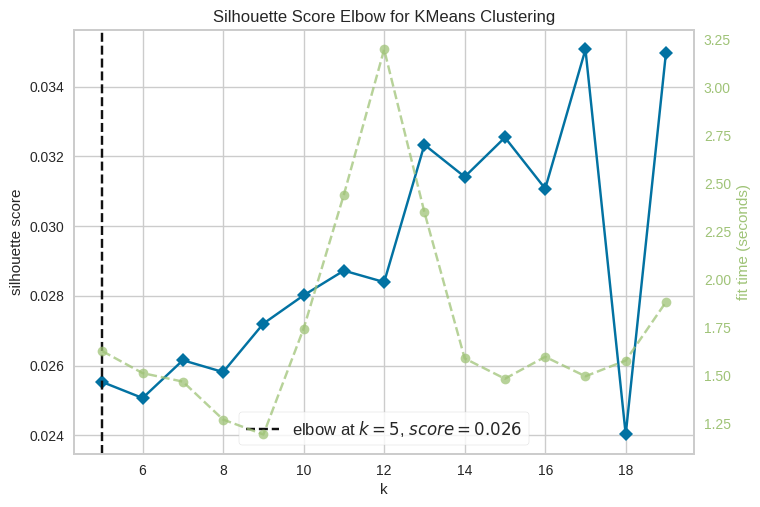

In [ ]:



model = KMeans(n_init='auto')

visualizer = KElbowVisualizer(model, k=(5, 20), metric='silhouette',init='k-means++')
visualizer.fit(embedding)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data
plt.show()

In [ ]:
NB_CLUSTER = 17
km = KMeans(n_clusters=NB_CLUSTER, random_state=33,n_init='auto', init='k-means++')
km.fit(embedding)


KMeans(n_clusters=17, n_init='auto', random_state=33)

In [ ]:
labels = km.labels_.tolist()

In [ ]:
frame = pd.DataFrame({'words': s_corpus,'text_encoded': corpus, 'cluster' : labels}, index = labels)

In [ ]:
frame[frame['cluster'] == 0 ].head()

,words,text_encoded,cluster
0,"[Convert, HTML, Text, looking, convert, HTML, ...","[(24, 1), (69, 1), (79, 1), (118, 1), (156, 1)...",0
0,"[Populate, WinForms, TreeView, DataTable, WinF...","[(19, 2), (21, 1), (39, 1), (62, 1), (75, 1), ...",0
0,"[CMake, converting, build, system, cmake, syst...","[(203, 1), (433, 1), (597, 1), (714, 1), (836,...",0
0,"[EDIT, file, React, UPDATE, lied, lack, knowle...","[(21, 2), (25, 1), (30, 2), (61, 1), (62, 1), ...",0
0,"[parse, flat, tree, Assume, flat, store, order...","[(19, 1), (24, 1), (53, 1), (181, 1), (260, 1)...",0


In [ ]:
kmeas_topics = []
for i in range(17) :
  topic = frame[frame['cluster'] == i ]['words'].explode().value_counts().head(20).index
  kmeas_topics.append(topic)

In [ ]:
kmeas_topics

[Index(['failed', 'open', 'convert', 'node', 'foreach', 'Invalid', 'supplied',
        'argument', 'Warning', 'Notice', 'index', 'Role.php', 'Soccer',
        'Undefined', 'button', 'format', 'print', 'file', 'byte', 'channel'],
       dtype='object'),
 Index(['Google', 'certificate', '.NET', 'password', 'Windows', 'model',
        'Visual', 'ASP.NET', 'client', 'script', 'token', 'database', 'Studio',
        'Core', 'build', 'connection', 'information', 'email', 'able',
        'framework'],
       dtype='object'),
 Index(['comment', 'user', 'SELECT', 'WHERE', 'FROM', 'parent_comment_id',
        'active_model_serializers', 'Load', 'Comment', 'LIMIT', 'CACHE',
        '0.0ms', 'template', 'parameter', 'variable', 'print', 'argument',
        'pointer', 'DWORD', 'value'],
       dtype='object'),
 Index(['file', 'Windows', 'Time', 'load', 'File', 'install', 'work', 'start',
        'memory', 'command', 'href=', 'value=', 'database', 'button',
        'emulator', 'build', 'script', 'And

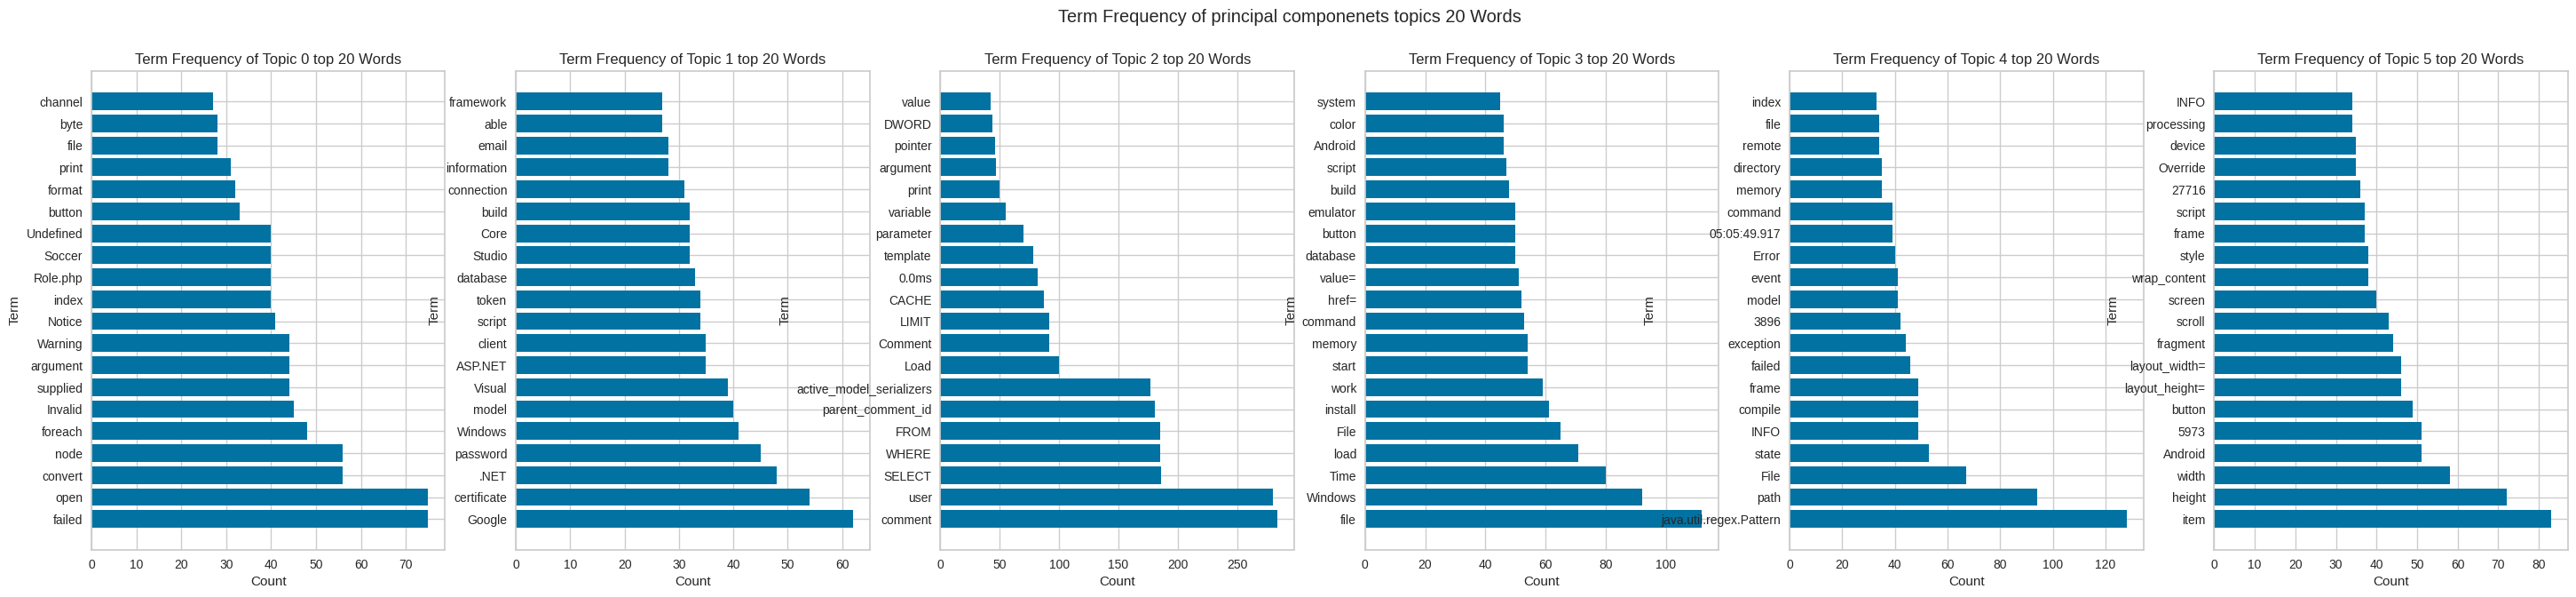

In [ ]:
def k_means_topic_df(topics_words, topics_weight, dic):

    words = []
    for i in range(len(topics_weight)):
        data = {
                "term" : topics_words[i],
                "term_weight" : topics_weight[i]
            }
        words.append(pd.DataFrame([data]))

    term_freq_df =  pd.concat(words)
    return term_freq_df

NB_TOPICS = 6
kmeas_topics = []
term_freq_df = []
for i in range(NB_CLUSTER) :
  topic_words = frame[frame['cluster'] == i ]['words'].explode().value_counts().head(20).index
  topic_count = frame[frame['cluster'] == i ]['words'].explode().value_counts().head(20).values
  kmeas_topics.append(topic)
  words = []
  for i in range(len(topics_weight)):
    data = {
            "term" : topic_words[i],
            "term_weight" : topic_count[i]
        }
    words.append(pd.DataFrame([data]))
  term_freq_df.append( pd.concat(words))

fig , axs = plt.subplots(1,NB_TOPICS,figsize=(6*NB_TOPICS,7))
for k in range(NB_TOPICS) :
    df = term_freq_df[k]
    # axs[k].clf()
    axs[k].barh(
        df['term'],
        df['term_weight']
    )
    axs[k].set_xlabel("Count")
    axs[k].set_ylabel("Term")
    axs[k].set_title(f"Term Frequency of Topic {k} top {N} Words")
fig.suptitle(f"Term Frequency of principal componenets topics {N} Words")
plt.show()


In [ ]:


coherence_model_u_mass = CoherenceModel(topics=kmeas_topics, corpus=corpus, dictionary=id2word, coherence='u_mass')
u_mass_kmeans = coherence_model_u_mass.get_coherence()
print(u_mass_kmeans)

-12.306074658037259


In [ ]:
# topic_cor = Topics.apply(lambda x : id2word.doc2bow(x))

coherence_model_c_v = CoherenceModel(topics=kmeas_topics, texts=s_corpus, dictionary=id2word, coherence='c_v')
c_v_kmeans = coherence_model_c_v.get_coherence()
print(c_v_kmeans)

0.4857539614223436


# Unsupervised learning model selection

In [ ]:
u_mass_scores = [u_mass_lsa, u_mass_lda, u_mass_kmeans]
c_v_scores = [c_v_lsa, c_v_LDA, c_v_kmeans]
result_coherence_scores = pd.DataFrame(
    {
        'u_mass_scores' : u_mass_scores,
        'c_v_scores' : c_v_scores
    }, index = ['lsa','lda','kmeans']
)


In [ ]:
result_coherence_scores

,u_mass_scores,c_v_scores
lsa,-7.234623,0.349950
lda,-7.871950,0.475715
kmeans,-12.306075,0.485754


The unsupervised model selected is **LDA**.

In [ ]:
## Cluster representation    

In [ ]:
lda_model_tunned[sto_body[0]]

NameError: name 'lda_model_tunned' is not defined

In [ ]:
text_corpus[0]

"NLTK - Automatically translating similar wordsBig picture goal: I am making an LDA model of product reviews in Python using NLTK and Gensim. I want to run this on varying n-grams. \nProblem: Everything is great with unigrams, but when I run with bigrams, I start to get topics with repeated information. For example, Topic 1 might contain: ['good product', 'good value'], and Topic 4 might contain: ['great product', 'great value']. To a human these are obviously conveying the same information, but obviously 'good product' and 'great product' are distinct bigrams. How do I algorithmically determine that 'good product' and 'great product' are similar enough, so I can translate all occurrences of one of them to the other (maybe the one that appears more often in the corpus)?\nWhat I've tried: I played around with WordNet's Synset tree, with little luck. It turns out that good is an 'adjective', but great is an 'adjective satellite', and therefore return None for path similarity. My thought 

In [ ]:
sto_body[0]

['picture',
 'goal',
 'making',
 'model',
 'product',
 'review',
 'Python',
 'NLTK',
 'Gensim',
 'varying',
 'Problem',
 'Everything',
 'great',
 'unigrams',
 'bigram',
 'start',
 'topic',
 'repeated',
 'information',
 'Topic',
 'might',
 'contain',
 "'good",
 'product',
 "'good",
 'Topic',
 'might',
 'contain',
 "'great",
 'product',
 "'great",
 'human',
 'obviously',
 'conveying',
 'information',
 'obviously',
 "'good",
 'product',
 "'great",
 'product',
 'distinct',
 'bigram',
 'algorithmically',
 'determine',
 "'good",
 'product',
 "'great",
 'product',
 'similar',
 'enough',
 'translate',
 'occurrence',
 'maybe',
 'appears',
 'often',
 'corpus',
 'played',
 'around',
 'WordNet',
 'Synset',
 'tree',
 'little',
 'luck',
 'turn',
 'good',
 "'adjective",
 'great',
 "'adjective",
 'satellite',
 'therefore',
 'None',
 'path',
 'similarity',
 'thought',
 'process',
 'Part',
 'speech',
 'sentence',
 'correct',
 'Synset',
 'Compute',
 'similarity',
 'Synsets',
 'threshold',
 'compute',
 'o

### Compare with supervised approach : average precision and jaccard scores. 
## Cluster representation    